<br>

**Quantitative Asset Allocation**
<br>
**Individual Project | Pension Fund Investment Strategy**

Created on Mar 2022
<br>
Lecturer: Joo Hee Lee
<br>
TA: Enrico Vicentini
<br>
Author@ Luning Gao
<br>

# -------------------Summary-----------------------

## Backgroud
Our client is a highly-respected large cap company which has a significant sum of assets in
their corporate pension, and would like one component of their pension assets to be
invested in a fixed-maturity multi-asset scheme with a regular payout.

The main characteristics of this special portion of pension are the following:
- All assets will be given back to the retirees in 10 years
- The initial investment is €120M, and each month, the payout should be
MAX(€1.001M,P), where P is the 1/n fraction of total remaining assets each month,
where n is the number of remaining months to the maturity (i.e. 1/120 for the first
payout and 1/119 for the second etc)
- It is in the retiree’s interest to maximise P
- If the remaining total assets become less than €1.001M, however, this company is
liable to meet the shortfall

Your report should include the elements listed below:
- What kind of investment strategy would you propose to our client?
- Why would our client implement your strategy?
- How likely would your strategy lead our client to the case of meeting shortfalls?
- Support your strategy by using historical data

##### Highlights:
##### Our client is a highly-respected large cap company which has a significant sum of assets
##### in their corporate pension, and would like one component of their pension assets to be 
##### invested in a fixed-maturity multi-asset scheme with a regular payout.

## Requirements
#### Regarding the requirement of clients, we need to be clear about the followings:
#### 1). The investment horizon is 10 years, which allows us to do long-term investment strategies.
#### 2). This is a pension fund, which requires us to adopt a relatively prudent investment strategy.
#### 3). Payout is required every month, which requires us to allocate assets at a high liquidity level.
#### 4). Because its pension fund, we assume we should not prefer a leverage to up the risk.

## Proposal
#### Methodology is that we set a target risk for each class, and optimize the best return of each class at the given tartget risk by our algorithm trying different weight combinaiton. After determine the return of each class, we select the proper weight combination for the three classes using efficient frontier to get the final portfolio return.
### Dynamic Allocation Strategy -- for Risk Adjustment
#### 1). We propose the strategy of rebalancing during the investment period, with different 
#### weights for assets regarding to the length till the marturity date. 
#### 2). Rebalance Monthly with a higher weight allocated to Equity assets in the first 84 months
#### of investment period, and higher weight allocated to Fixed Income assets in the last 36 
#### months, to achieve higher return in the early stage and decrease the volitility of our 
#### portfolio in the later stage, in order to reduce the affect by the unpredictable volatile market risk as the
#### time goes toward the maturity date.
### Target Risk Strategy -- for Multi-Asset Allocation
#### 1). Our porfolio will consist of three classes ：Equity, Fixed Income, Commodity.
#### > Equity class will be made up of ETF assets regarding to different sectors and markets.
#### > Fixed Income class will consist of secruities in different maturities and yield.
#### > Commodity class will consist of Gold and Oil for hedging against the unpredicted volatile period of market.
#### 2). With comparing 3 strategies, Target Risk Strategy achieved the best performance. Our algorithm
#### give the best return at the pre-set target risk.
#### > Set target risk for allocating weights to assets in Equity, Fixed Income, and Commodity Classes
#### and give the weight of assets at the target volatility
#### > Set optimal weights on Efficient Frontier for allocating weights among three classes.
### Performance of Strategy
#### The portfolio is decided by the algorithm as below:
#### Allocation for the month 1th - 84th: [ Fixed Income: 6.29%, Equity: 74.72%, Commodity: 18.99% ]
#### Allocation for the month 85th -120th: [ Fixed Income: 49.23, Equity: 40.49%, Commodity: 10.28% ]
#### Equity [ Technology：80.7%, Health Care: 14.7%, Consumers: 3.8%, Real Estate: 0.8% ]
#### Fixed Income [ Corp HY: 70.6%, 7-10yrs TIPS: 21.2%, AGG: 8.2% ]
#### Commodity [ Oil: 39,9%, Gold: 60.1% ]
#### This strategy would achieve stable and increasing payouts, by the simulation, generating 
#### 216.44 Million USD in total, at a ROIC of 80.37%.

# ---------------------Analysis-----------------------

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy.optimize as sco
from bokeh.transform import cumsum
from bokeh.palettes import Category20c, all_palettes, Spectral6
from bokeh.models import HoverTool, DatetimeTickFormatter
from bokeh.models import NumeralTickFormatter, ColumnDataSource
from bokeh.models import Legend, Span
from bokeh.plotting import figure, show
import seaborn as sns
import bokeh.resources
from bokeh.io import output_notebook, show
from scipy.stats import norm
import scipy 
import os

##### Plot Funcitons

In [3]:
def plotIndex(RetIndex:pd.DataFrame, title:str):
    numlines=len(RetIndex.columns)
    source = RetIndex
    mypalette=all_palettes['Category20c'][numlines]
    [name for name in RetIndex]
    p = figure(width=800, height=400,
               title=title, 
               x_axis_label='Dates', 
               y_axis_label='Return Index') 

    for index, asset in enumerate(RetIndex.columns):
        color = all_palettes['Category20'][len(RetIndex.columns)][index]
        p.line(RetIndex.index,
               RetIndex[asset],
               legend_label=asset,
               color=color)

    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    p.xaxis.formatter = DatetimeTickFormatter(days=["%d %b %Y"],
                                              months=["%d %b %Y"],
                                              years=["%d %b %Y"])
    p.add_tools(HoverTool())
    return p

In [4]:
def makeStackPlot(series: dict, assets: list, dateStart: datetime):
    
    percentDF = pd.DataFrame(series.values(), columns=assets)
    percentDF['dates'] = list(series.keys())
    weights = ColumnDataSource(data=percentDF)

    portfolioWeightsPlot = figure(title='Portfolio Weights', 
                                  x_axis_label='Dates', 
                                  y_axis_label='Weights',
                                  x_range=(dateStart, max(series.keys())+timedelta(days=90)),
                                  plot_width=800,
                                  plot_height=400)
    
    portfolioWeightsPlot.varea_stack(stackers=assets, 
                                     x='dates',
                                     color=all_palettes['Category20c'][len(assets)],
                                     legend_label=assets, 
                                     source=weights)
    
    portfolioWeightsPlot.legend.location = "top_left"
    portfolioWeightsPlot.legend.border_line_width = 0
    portfolioWeightsPlot.legend.click_policy = "hide"
    portfolioWeightsPlot.legend.background_fill_color = "white"
    portfolioWeightsPlot.xaxis.formatter = DatetimeTickFormatter(days=["%d %b %Y"], months=["%d %b %Y"],
                                                                 years=["%d %b %Y"])
    portfolioWeightsPlot.xgrid.grid_line_color = None
    portfolioWeightsPlot.add_tools(HoverTool())
    return portfolioWeightsPlot

In [5]:
def makePortfolioVolatilityPlot(volatility: dict, targetVol:float, dateStart:datetime ):
    volatilityDF = pd.DataFrame.from_dict(volatility, orient='index', columns=['Volatility'])
    volatilityPlot = figure(toolbar_location='below',
                            title='Portfolio Volatility',
                            x_axis_label='Dates',
                            y_axis_label='Volatility',
                            x_range=(dateStart, max(volatility.keys())+timedelta(days=90)),
                            y_range=(0, 0.10),
                            plot_width=800,
                            plot_height=400)
    
    volatilityPlot.line(volatilityDF.index,
                        volatilityDF['Volatility'],
                        line_width=3)
    
    volatilityPlot.yaxis[0].formatter = NumeralTickFormatter(format="0.00%")
    volatilityPlot.xaxis.formatter = DatetimeTickFormatter(days=["%d %b %Y"],
                                                           months=["%d %b %Y"],#;[']LOP980OL MNGT5']
                                                           years=["%d %b %Y"])
    
    span = Span(location=targetVol,
                dimension='width',
                line_color='orange',
                line_dash='dashed',
                line_width=2)
    volatilityPlot.add_layout(span)
    volatilityPlot.add_tools(HoverTool())
    return volatilityPlot

##### Data Process Functions

In [6]:
def read_file(fnames, path):
    f = pd.read_excel(path + fnames[0],index_col=0)
    f.index.name = None
    f=f.drop(f.index[0:6])
    f=f.drop(columns=['Unnamed: 2'])
    f=f.sort_index()
    f=f.tail(230)
    f=f.drop(f.columns[0], axis=1)
    return f

def read_fileloop(fnames,path,nf):
    for i in range(len(fnames)):
        try:
            f= pd.read_excel(path + fnames[i],index_col=0)
            f.index.name = None
            f=f.drop(f.index[0:6])
            f=f.drop(columns=['Unnamed: 2'])
            f=f.sort_index()
            f=f.tail(230)
            nf=pd.concat([nf,f],axis=1) 
        except Exception as e:
            pass
        continue 
    return nf

def get_rets(tbl):
    r = tbl.pct_change()[1:]
    r.loc[pd.to_datetime('2003-01-31')]=0
    r=r.sort_index()
    return r

In [29]:
#rm -f .DS_Store
eq_path='/Users/luninggao/Desktop/eq idx/'
eqnames = os.listdir(eq_path)
ft_eq=read_file(eqnames,eq_path)
ft_eq=read_fileloop(eqnames,eq_path,ft_eq)
ft_eq.columns=[s.replace('.xlsx', "") for s in eqnames]

In [30]:
eq_rets=get_rets(ft_eq)
eq_rets.drop(eq_rets.tail(1).index,inplace=True)
equityReturns=eq_rets
equityTickers=equityReturns.columns

In [31]:
fi_path='/Users/luninggao/Desktop/fi idx/'
finames = os.listdir(fi_path)
ft_fi=read_file(finames,fi_path)
ft_fi=read_fileloop(finames,fi_path,ft_fi)
ft_fi.columns=[s.replace('.xlsx', "") for s in finames]

In [32]:
fi_rets=get_rets(ft_fi)
fixedReturns =fi_rets
fixedIncomeTickers=fixedReturns.columns

In [33]:
cmm_path='/Users/luninggao/Desktop/cmm idx/'
cmmnames = os.listdir(cmm_path)
ft_cmm=read_file(cmmnames,cmm_path)
ft_cmm=read_fileloop(cmmnames,cmm_path,ft_cmm)
ft_cmm.columns=[s.replace('.xlsx', "") for s in cmmnames]

In [34]:
cmm_rets=get_rets(ft_cmm)
commReturns =cmm_rets
commTickers=commReturns.columns

##### Stats Functions

In [35]:
def logReturn(data: pd.DataFrame) -> pd.DataFrame:
    logReturn=np.log(data/data.shift(1))
    return logReturn[1:]

def percentageReturn(data) -> pd.DataFrame:
    percReturn =data.pct_change() 
    return percReturn[1:]

def returnIndex(returns: pd.DataFrame, dateStart: datetime) -> pd.DataFrame:
    retIndex=(1+returns).cumprod()*100
    retIndex.loc[pd.to_datetime(dateStart)] = 100
    retIndex = retIndex.sort_index()
    retIndex = pd.DataFrame(retIndex)
    return retIndex 

def getMean(returns: pd.DataFrame) -> pd.DataFrame:
    meanYearly = np.round(((returns)*12).mean(),3)
    return meanYearly

def getVolatility(returns: pd.DataFrame) -> pd.DataFrame:
    volYearly = np.round(returns.std()*np.sqrt(12),3)
    return volYearly

def getCovariance(returns: pd.DataFrame) -> pd.DataFrame:
    covYearly = returns.cov() * 12
    return covYearly

def getCorrelation(returns: pd.DataFrame) -> pd.DataFrame:
    corrYearly =np.round(returns.corr(),3)
    return corrYearly

dateStart = datetime(2003,1,31)
dateToday = datetime(2022,1,31)


In [36]:
def statsEF(weights):
    weights = np.array(weights)
    pret = np.sum(combinedReturns.mean() * weights)*12
    pvol = np.sqrt(np.dot(weights.T, np.dot(combinedReturns.cov()*12, weights)))
    return np.array([pret, pvol, pret / pvol])

In [37]:
def min_func_var(weights):
    return statsEF(weights)[1]**2

##### Optimization Functions

In [38]:
def riskConstribution(weights, covariance):
    portVariance = np.dot(weights.T, np.dot(covariance, weights))
    margConstribution = covariance @ weights
    riskConstribution = np.multiply(margConstribution, weights.T) / portVariance
    return riskConstribution

In [39]:
def getERC(weights, covariance, targetRisk) -> float:
    ercContributions = riskConstribution(weights, covariance)
    return ((ercContributions-targetRisk)**2).sum()

In [40]:
def OptimizationERC(returns: pd.DataFrame, assets: list):
    cons = ({"type" : "eq", "fun" : lambda x: np.sum(x) - 1}) 
    bnds = tuple((0.0,1) for x in range(len(assets))) 
    initial = np.repeat(1 / len(assets), len(assets)) #Optimization beging from the equally weighted portfolio
    targetRisk = np.repeat((1 /len(assets)), len(assets))
    covariance = returns.cov() * 12
    opt = sco.minimize(getERC, initial, args=(covariance, targetRisk), method="SLSQP", bounds=bnds, constraints=cons)
    return opt

In [41]:
def stats(weights,returns):
    weights = np.array(weights)
    pret = np.sum(returns.mean() * weights)*12
    pvol = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*12, weights)))
    return np.array([pret, pvol, pret/ pvol])

In [42]:
def min_func_variance(weights,returns):
    return stats(weights,returns)[1]**2

In [43]:
def minVariance(returns: pd.DataFrame):
    cons = ({"type" : "eq", "fun" : lambda x: np.sum(x) - 1}) #Wealth assumption
    bnds = tuple((0.0,1) for x in range(len(returns.columns))) # Can't go short
    initial = np.repeat(1 / len(returns.columns), len(returns.columns))
    optv = sco.minimize(min_func_variance, initial, args=(returns), 
                        method="SLSQP", bounds=bnds, constraints= cons)
    return optv

In [44]:
def min_func_variance(weights, covariance):
    weights = np.array(weights)
    pvar = np.dot(weights.T, np.dot(covariance, weights))
    return pvar 

In [45]:
def OptimizationMinVar(returns: pd.DataFrame, assets: list):
    cons = ({"type" : "eq", "fun" : lambda x: np.sum(x) - 1}) #Wealth assumption
    bnds = tuple((0.0,1) for x in range(len(assets))) # Can't go short
    initial = np.repeat(1 / len(assets), len(assets)) #Optimization beging from the equally weighted portfolio
    targetRisk = np.repeat((1 /len(assets)), len(assets))
    covariance = returns.cov() * 12
    opt = sco.minimize(min_func_variance, initial, args=(covariance), method="SLSQP", bounds=bnds, constraints=cons)
    return opt

In [46]:
def maxReturn(weights,returns):
    return -stats(weights,returns)[0]

In [47]:
def OptimizationTarRisk(returns: pd.DataFrame, assets: list, tarR):
    cons = ({"type" : "eq", "fun" : lambda x: np.sum(x) - 1},{"type" : "eq", "fun" : lambda x: stats(x,returns)[1] - tarR})
    bnds = tuple((0.0,1) for x in range(len(assets)))
    initial = np.repeat(1 / len(assets), len(assets))
    opt = sco.minimize(maxReturn,initial,args=(returns), method="SLSQP", bounds=bnds, constraints=cons)
    return opt

##### Backtest Functions

In [48]:
def backtestERC(returns: pd.DataFrame, dateToday:datetime, lookback:int = 12*10):#previous lookback:int=12*10
    returnsCopy = returns
    weights = {}
    portVol = {}
    for index in range(len(returnsCopy.index)-lookback+1):
        rollingData = returnsCopy.iloc[index : int(lookback) + index]
        covariance = rollingData.cov() * 12
        opt = OptimizationERC(rollingData, returns.columns.to_list())
        weights[max(rollingData.index)] = opt['x']
        portVol[max(rollingData.index)] = np.sqrt(np.dot(opt['x'].T, np.dot(covariance, opt['x'])))
    return weights, portVol

In [49]:
def backtestMinVariance(returns: pd.DataFrame, dateToday:datetime, lookback:int = 12*10):
    returnsCopy = returns
    weights = {}
    portVol = {}
    for index in range(len(returnsCopy.index)-lookback):
        rollingData = returnsCopy.iloc[index : int(lookback) + index]
        covariance = rollingData.cov() * 12
        opt = OptimizationMinVar(rollingData, list(returns.columns))
        weights[max(rollingData.index)] = opt['x']
        portVol[max(rollingData.index)] = np.sqrt(np.dot(opt['x'].T, np.dot(covariance, opt['x'])))
    return weights, portVol

In [50]:
def backtestMaxSR(returns: pd.DataFrame, dateToday:datetime, lookback:int = 12*10):
    returnsCopy = returns
    weights = {}
    portVol = {}
    for index in range(len(returnsCopy.index)-lookback):
        rollingData = returnsCopy.iloc[index : int(lookback) + index]
        covariance = rollingData.cov() * 12
        opt = maxSharpeRatio(rollingData)
        weights[max(rollingData.index)] = opt['x']
        portVol[max(rollingData.index)] = np.sqrt(np.dot(opt['x'].T, np.dot(covariance, opt['x'])))
    return weights, portVol

In [51]:
def backtestEqual(returns: pd.DataFrame, dateToday:datetime, lookback:int = 12*10):
    returnsCopy = returns
    weights = {}
    portVol = {}
    for index in range(len(returnsCopy.index)-lookback):
        rollingData = returnsCopy.iloc[index : int(lookback) + index]
        covariance = rollingData.cov() * 12
        weights[max(rollingData.index)] = equalWeight
        portVol[max(rollingData.index)] = np.sqrt(np.dot(equalWeight.T, np.dot(covariance, equalWeight)))
    return weights, portVol

In [52]:
def backtestSel(returns: pd.DataFrame, dateToday:datetime, lookback:int = 12*10):
    returnsCopy = returns
    weights = {}
    portVol = {}
    for index in range(len(returnsCopy.index)-lookback):
        rollingData = returnsCopy.iloc[index : int(lookback) + index]
        covariance = rollingData.cov() * 12
        weights[max(rollingData.index)] = selWeight
        portVol[max(rollingData.index)] = np.sqrt(np.dot(selWeight.T, np.dot(covariance, selWeight)))
    return weights, portVol

## 1. Portfolio Construction
### Our portfolio will consist of Equity, Fixed Income and Commodity
#### 1). Equity will be made up of ETF regarding to different sectors and markets: 
##### S&P500, Russell2000, Technology, Health Care, Real Estate
#### 2). Fixed Income consists of assets with different maturities and yield:
##### 7-10 year Tips, Corporate high yield bond and AGG
#### 3). Commodity is for a hedge against the unpredicted big swings in security market:
##### Gold and Oil

In [53]:
returns = pd.concat([fixedReturns, equityReturns, commReturns], axis=1)
returns.to_excel("returns.xlsx")
returns.head()

,Corp HY,7-10yrs TIPS,AGG,S&P500,RealEstate,NASDAQ,Europe,EmergingMKT,Industrials,Technology,Fianncials,Russell2000,Health,Japan,Consumers,OIL,GOLD
2003-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-02-28,0.012333,0.034324,0.013837,-0.017004,0.014217,0.012575,0.024724,-0.031504,-0.018350,0.024164,-0.032784,-0.031310,-0.019379,0.002770,-0.029021,0.092211,-0.049436
2003-03-31,0.028764,-0.011496,-0.000771,0.008358,0.019989,0.002729,-0.011571,-0.032067,0.012184,-0.012180,-0.005963,0.011164,0.033611,-0.046673,-0.005904,-0.151913,-0.035719
2003-04-30,0.059330,-0.003148,0.008252,0.081044,0.043514,0.091815,0.086541,0.084108,0.105969,0.090149,0.120506,0.093650,0.033900,-0.017722,0.028909,-0.168814,0.003260
2003-05-30,0.010329,0.040419,0.018645,0.050899,0.060343,0.089872,0.031100,0.068672,0.026041,0.083658,0.050762,0.106160,0.016783,0.075732,0.047101,0.145736,0.076503


### 1.1. Display Historical Performance of Each Index 
#### Screening indices based on their historical performance
#### we use the historical data of assets from 2003.01.31 to 2022.01.31 as the observations window
#### we use the time window of 2013.01.31-2022.01.31 to do the BackTest

In [54]:
datos_returns = returns
datos_returns.dropna(inplace=True)

In [55]:
#annual performance
statspd = pd.DataFrame()
statspd['Annualized Returns(%)'] =datos_returns.mean() * 12 *100
statspd['Annualized Volatility(%)'] = datos_returns.std() * np.sqrt(12)*100
statspd['Sharpe Ratio'] = statspd['Annualized Returns(%)'] /statspd['Annualized Volatility(%)']
statspd=statspd.sort_values(by=['Annualized Returns(%)','Annualized Volatility(%)'], ascending=False)
statspd

,Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio
Technology,15.158487,17.796442,0.851771
NASDAQ,13.967560,16.974662,0.822848
OIL,12.927390,40.036624,0.322889
RealEstate,12.244052,21.053186,0.581577
Russell2000,10.810985,19.315521,0.559705
S&P500,9.760747,14.165874,0.689032
GOLD,9.755258,16.913809,0.576763
Industrials,9.726585,17.975948,0.541089
EmergingMKT,9.667866,20.663286,0.467877
Health,9.334088,13.323163,0.700591


#### According to the below descending order of average annualized returns, it can be seen that the annual returns of Technology and Real Estate are at the leading position, respectively 15.16% and 12.24%. 
#### In terms of regions, the U.S. market is leading, while the return of European market lagged behind others, respectively 13.96% and 4.72%.
#### In terms of volatility, Financials and Real Estate are the sectors having highest volatility, 21.52% and 21.05% respectively. 
#### From the regions perspective, the volatility of Emerging market and Japan are higher, which are 20.66% and 18.42% respectively, than that of the U.S. market.
#### In terms of Sharpe ratio, Technology and Real estate led with 0.85 and 0.82 respectively, followed by Health and Consumers sectors with 0.70 and 0.71 respectively.

In [56]:
print(60*'-')
print('Equity Annualized Statistics - since 2003')
statspd.style.bar(color=['red','green'], align='zero')

------------------------------------------------------------
Equity Annualized Statistics - since 2003


,Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio
Technology,15.158487,17.796442,0.851771
NASDAQ,13.967560,16.974662,0.822848
OIL,12.927390,40.036624,0.322889
RealEstate,12.244052,21.053186,0.581577
Russell2000,10.810985,19.315521,0.559705
S&P500,9.760747,14.165874,0.689032
GOLD,9.755258,16.913809,0.576763
Industrials,9.726585,17.975948,0.541089
EmergingMKT,9.667866,20.663286,0.467877
Health,9.334088,13.323163,0.700591


In [57]:
retIndex1 = returnIndex(fixedReturns, dateStart)
retIndex2 = returnIndex(equityReturns, dateStart)
retIndex3 =returnIndex(commReturns, dateStart)
retIndex = pd.concat([retIndex1, retIndex2, retIndex3], axis=1)
assets = retIndex.columns.tolist()

In [58]:
cumpond=retIndex2.sort_values(by = '2022-01-31', axis = 1).loc['2022-01-31']

### 1.2. Preliminary Selection of Assets
#### Regarding the comprehensive performance of returns and volatility of each assets, we remove assets with low returns and high volatility from our portfolio

In [59]:
removes=cumpond[:3].index
retIndex.drop(columns=removes, inplace=True)
retIndex2.drop(columns=removes, inplace=True)
equityReturns.drop(columns=removes, inplace=True)
returns.drop(columns=removes, inplace=True)
equityTickers=equityTickers.drop(removes)

In [60]:
assets = retIndex.columns.tolist()

#### The below graph shows the cumulative returns of each asset we keepin our portfolio.

In [61]:
p=plotIndex(retIndex,'Cumulative Return')
show(p)
output_notebook()

Loading BokehJS ...

#### Combined with the firgure of Correlation Matrix and Cumulative Return, we can see that the correlation coefficient between Gold and Equity is very small, while the correlation coefficient between Oil price and Bond market is Negative. 
#### Therefore, Gold and Oil are selected to make up the Commodity portfolio, as a hedging solution for the huge volatile period of stock and bond market.

Text(0.5, 1.0, 'CORRELATION MATRIX')

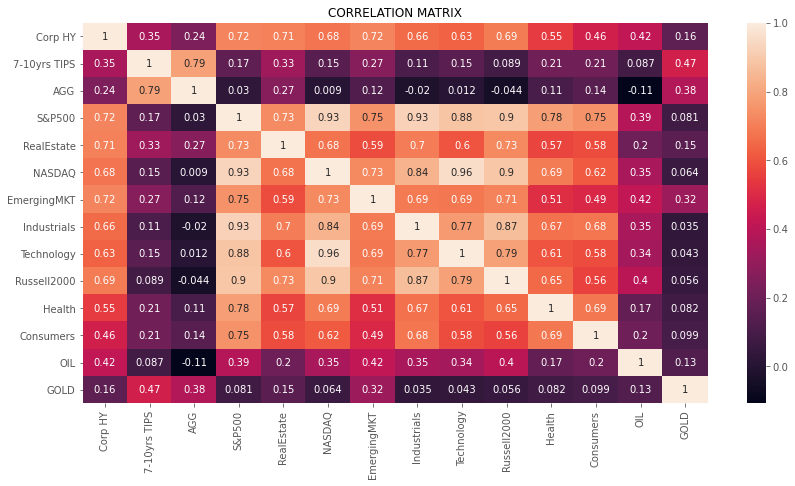

In [62]:
plt.figure(figsize=(14, 7))
sns.heatmap(getCorrelation(returns),annot = True)
plt.title('CORRELATION MATRIX', fontsize=12)

## 2. Optimization Strategy Comparison 
### We will compare several strategies in the following analysis, from both Return and Risk Management perspectives, including:
#### Strategy 1. ERC Optimization for every single asset
#### Strategy 2. Minimum Variance Optimization
#### Strategy 3. Target Risk for assets in each class

### Problems of using on Max SR and Min Var optimizations:
#### 1). These two optimizers is likely not able to allcate weight to every asset we select for our portfolio, in particular doesn't work on the multiple-asset portfolio. Partial assets only can get weights from these two optimizers.
#### 2). Only small part of assets can get weights cannot meet our diversification requirement on porfolio.
#### 3). In additon, the volatility and return are small, we have space to get higher return with taking higher risk.

### Result of this section.
#### By the end of this section, we got conclusion of using Target Risk Strategy to allocate weights in each class.

###
### 2.1. Strategy 1. 
#### ERC for Every Asset in the Portfolio, without distinguishing class among equity, fixed income, and commodity.

In [63]:
opt = OptimizationERC(returns, assets)
ercWeightsAll=pd.DataFrame(data=(opt['x']*100).round(1), index=assets, columns=['Weight%'] )

<AxesSubplot:title={'center':'Risk Constributions of an ERC portfolio'}>

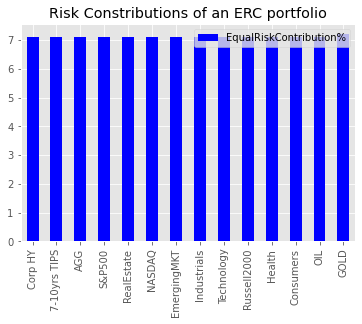

In [64]:
ercWeights = opt["x"]
covariance = returns.cov() * 12
rc = pd.DataFrame(riskConstribution(ercWeights, covariance))
rcPrecent=(rc*100).round(1)
rcPrecent.columns=['EqualRiskContribution%']
rcPrecent.plot.bar(color='b',title="Risk Constributions of an ERC portfolio")

#### 2.1.1. Portfolio Return and Volatility of ERC Strategy
#### We achieve an allocation that each asset contribute same risk for the portfolio with different weight. In this strategy, each asset give a risk of 7.1% to the portfolio, and we get a portfolio return of 0.073, and a volatility of 0.067

In [65]:
ercWeightsAll=pd.concat([ercWeightsAll,rcPrecent], axis=1)
ercWeightsAll.index.name='ERCforAll'

port_ret=np.dot(returns.mean(),ercWeights)*12
portVariance = np.dot(ercWeights.T, np.dot(covariance, ercWeights))
portVolatility = np.sqrt(portVariance)
print('Portfolio Return: {}'.format(round(port_ret,3)))
print('Portfolio Variance: {}'.format(round(portVariance,3)))
print('Portfolio Volatility: {}'.format(round(portVolatility,3)))

ercWeightsAll

Portfolio Return: 0.073
Portfolio Variance: 0.005
Portfolio Volatility: 0.067


,Weight%,EqualRiskContribution%
ERCforAll,,
Corp HY,6.7,7.1
7-10yrs TIPS,14.2,7.1
AGG,34.9,7.1
S&P500,3.9,7.1
RealEstate,2.9,7.1
NASDAQ,3.5,7.1
EmergingMKT,2.9,7.1
Industrials,3.4,7.1
Technology,3.5,7.1


#### 2.1.2.Backtest for Strategy 1
#### This Strategy amis to relance our portfolio with ERC of each asset in each period.
#### The below two tables are weights allocation for each assets in each period and the return table in backtest period

In [66]:
weights, portVol= backtestERC(returns, dateToday)

In [69]:
weight_pd=pd.DataFrame.from_dict(weights).T
weight_pd.columns=returns.columns
weight_pd_percent=round(weight_pd*100,2)
weight_pd_percent.index.name='weight%'
weight_pd_percent.head()

,Corp HY,7-10yrs TIPS,AGG,S&P500,RealEstate,NASDAQ,EmergingMKT,Industrials,Technology,Russell2000,Health,Consumers,OIL,GOLD
weight%,,,,,,,,,,,,,,
2012-12-31,6.09,13.16,36.50,3.88,2.57,3.38,2.47,3.32,3.37,3.06,5.57,6.92,3.28,6.42
2013-01-31,6.08,13.17,36.71,3.85,2.57,3.37,2.47,3.31,3.37,3.05,5.52,6.85,3.26,6.43
2013-02-28,6.08,13.17,36.72,3.86,2.57,3.36,2.47,3.31,3.37,3.05,5.52,6.88,3.25,6.40
2013-03-29,6.03,13.21,36.85,3.84,2.56,3.35,2.48,3.30,3.36,3.04,5.44,6.85,3.28,6.42
2013-04-30,6.07,13.09,37.01,3.85,2.55,3.37,2.49,3.32,3.38,3.05,5.42,6.84,3.19,6.38


In [70]:
ret_back=round(returns.tail(110),5)

In [71]:
port_rets=(ret_back*weight_pd).sum(axis=1)
port_rets=pd.DataFrame(port_rets)
port_rets.columns=['Portfolio Return']

In [72]:
ERCportIndex = returnIndex(port_rets,datetime(2012,12,31))
ERCportIndex.columns=['ERC Portfolio Return']
benchmark=retIndex[['AGG','S&P500']]
ERCportIndex = pd.concat([ERCportIndex, benchmark.tail(110)], axis=1)

#### Comparison with Benchmarks
#### In the backtest of time window from 2013 to the date, we compare Portfolio Cumulative Return with AGG and S&P500 as Benchmarks. We can see this strategy cannot give us a satisfied return.

In [73]:
p=plotIndex(ERCportIndex,'Cumulative Return')
show(p)
output_notebook()

Loading BokehJS ...

In [186]:
output_notebook()
show(makeStackPlot(weights, assets, dateStart))

Loading BokehJS ...

### 2.2. Strategy 2.
#### ERC for assets within each class(Equity, FixedIncome, Commodity)
#### Minimum Variance for allocation assets among classes, for the whole portfolio

#### 2.2.1. ERC Optimization for Equity

In [187]:
equityOpt = OptimizationERC(equityReturns, equityTickers)

In [188]:
print('Equal Risk Contribution for Equity set:')
ercEquity=pd.DataFrame(data=(equityOpt['x']*100).round(1), index=equityTickers, columns=['Weight%'] )
ercEquity

Equal Risk Contribution for Equity set:


,Weight%
S&P500,11.1
RealEstate,9.2
NASDAQ,9.7
EmergingMKT,9.4
Industrials,9.4
Technology,9.9
Russell2000,8.8
Health,14.6
Consumers,17.9


<AxesSubplot:title={'center':'Equal Risk Constributions of Equity portfolio'}>

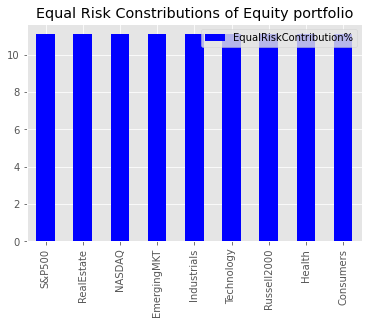

In [189]:
equityERCWeights = equityOpt["x"]
equityCovariance = equityReturns.cov() * 12
rc = pd.DataFrame(riskConstribution(equityERCWeights, equityCovariance))
rcPrecent=(rc*100).round(1)
rcPrecent.columns=['EqualRiskContribution%']
rcPrecent.plot.bar(color= 'b', title="Equal Risk Constributions of Equity portfolio")

#### We got a equity porfolio with return of 0.116, and volatility of 0.148

In [190]:
ercEquity=pd.concat([ercEquity,rcPrecent], axis=1)
#note strategy name
ercEquity.index.name='ERCforEquity'

port_ret_Eq=np.dot(equityReturns.mean(),equityERCWeights)*12
portVariance_Eq = np.dot(equityERCWeights.T, np.dot(equityCovariance, equityERCWeights))
portVolatility_Eq = np.sqrt(portVariance_Eq)
print('Portfolio Return: {}'.format(round(port_ret_Eq,3)))
print('Portfolio Variance: {}'.format(round(portVariance_Eq,3)))
print('Portfolio Volatility: {}'.format(round(portVolatility_Eq,3)))

ercEquity

Portfolio Return: 0.106
Portfolio Variance: 0.019
Portfolio Volatility: 0.139


,Weight%,EqualRiskContribution%
ERCforEquity,,
S&P500,11.1,11.1
RealEstate,9.2,11.1
NASDAQ,9.7,11.1
EmergingMKT,9.4,11.1
Industrials,9.4,11.1
Technology,9.9,11.1
Russell2000,8.8,11.1
Health,14.6,11.1
Consumers,17.9,11.1


#### 2.2.2. ERC Optimization for Fixed Income

In [191]:
fixedOpt = OptimizationERC(fixedReturns, fixedIncomeTickers)

In [192]:
print('Equal Risk Contribution for Fixed Income set:')
ercFixIn=pd.DataFrame(data=(fixedOpt['x']*100).round(1), index=fixedIncomeTickers, columns=['Weight%'] )
ercFixIn

Equal Risk Contribution for Fixed Income set:


,Weight%
Corp HY,22.5
7-10yrs TIPS,26.5
AGG,51.0


<AxesSubplot:title={'center':'Equal Risk Constributions of Fixed Income portfolio'}>

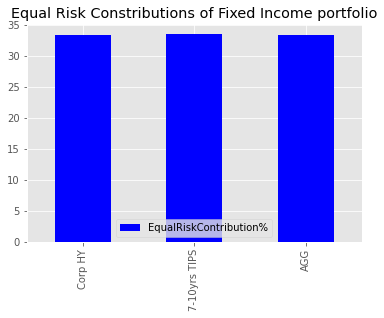

In [193]:
fixedInERCWeights = fixedOpt["x"]
fixedInCovariance = fixedReturns.cov() * 12
rc = pd.DataFrame(riskConstribution(fixedInERCWeights, fixedInCovariance))
rcPrecent=(rc*100).round(1)
rcPrecent.columns=['EqualRiskContribution%']
rcPrecent.plot.bar(color= 'b', title="Equal Risk Constributions of Fixed Income portfolio")

#### We got a fixed income porfolio with return of 0.045, and volatility of 0.036

In [194]:
ercFixIn=pd.concat([ercFixIn,rcPrecent], axis=1)
#note strategy name
ercFixIn.index.name='ERCforFixedIn'

port_ret_FixedIn=np.dot(fixedReturns.mean(),fixedInERCWeights)*12
portVariance_FixedIn = np.dot(fixedInERCWeights.T, np.dot(fixedInCovariance, fixedInERCWeights))
portVolatility_FixedIn = np.sqrt(portVariance_FixedIn)
print('Portfolio Return: {}'.format(round(port_ret_FixedIn,3)))
print('Portfolio Variance: {}'.format(round(portVariance_FixedIn,3)))
print('Portfolio Volatility: {}'.format(round(portVolatility_FixedIn,3)))

ercFixIn

Portfolio Return: 0.051
Portfolio Variance: 0.002
Portfolio Volatility: 0.043


,Weight%,EqualRiskContribution%
ERCforFixedIn,,
Corp HY,22.5,33.3
7-10yrs TIPS,26.5,33.4
AGG,51.0,33.3


#### 2.2.3. ERC Optimization for Commodity

In [195]:
commOpt = OptimizationERC(commReturns, commTickers)

In [196]:
print('Equal Risk Contribution for Commodity set:')
ercComm=pd.DataFrame(data=(commOpt['x']*100).round(1), index=commTickers, columns=['Weight%'] )
ercComm

Equal Risk Contribution for Commodity set:


,Weight%
OIL,29.7
GOLD,70.3


<AxesSubplot:title={'center':'Equal Risk Constributions of Commodity portfolio'}>

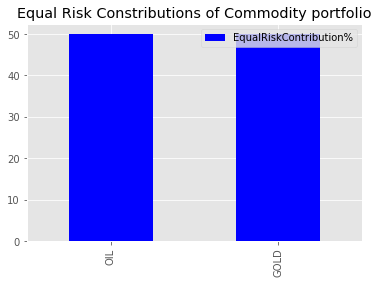

In [197]:
commERCWeights = commOpt["x"]
commCovariance = commReturns.cov() * 12
rc = pd.DataFrame(riskConstribution(commERCWeights, commCovariance))
rcPrecent=(rc*100).round(1)
rcPrecent.columns=['EqualRiskContribution%']
rcPrecent.plot.bar(color= 'b', title="Equal Risk Constributions of Commodity portfolio")

#### We got a commodity porfolio with return of 0.107, and volatility of 0.179

In [198]:
ercComm=pd.concat([ercComm,rcPrecent], axis=1)
#note strategy name
ercComm.index.name='ERCforComm'

port_ret_comm=np.dot(commReturns.mean(),commERCWeights)*12
portVariance_comm = np.dot(commERCWeights.T, np.dot(commCovariance, commERCWeights))
portVolatility_comm = np.sqrt(portVariance_comm)
print('Portfolio Return: {}'.format(round(port_ret_comm,3)))
print('Portfolio Variance: {}'.format(round(portVariance_comm,3)))
print('Portfolio Volatility: {}'.format(round(portVolatility_comm,3)))

ercComm

Portfolio Return: 0.107
Portfolio Variance: 0.032
Portfolio Volatility: 0.179


,Weight%,EqualRiskContribution%
ERCforComm,,
OIL,29.7,50.0
GOLD,70.3,50.0


#### 2.2.4. Minimum Variance Optimization for allocation of the three classes

In [199]:
combinedFixedReturns = (fixedInERCWeights * fixedReturns).sum(axis=1)
combinedEquityReturns = (equityERCWeights * equityReturns).sum(axis=1)
combinedCommReturns = (commERCWeights * commReturns).sum(axis=1)

In [200]:
combinedReturns = pd.concat([combinedFixedReturns,combinedEquityReturns,combinedCommReturns], axis=1)
combinedAssets = ['Fixed Income', 'Equity','Commodity']
combinedReturns.columns = combinedAssets
combinedReturns.head()

,Fixed Income,Equity,Commodity
2003-01-31,0.000000,0.000000,0.000000
2003-02-28,0.018933,-0.012460,-0.007368
2003-03-31,0.003022,0.004776,-0.070228
2003-04-30,0.016707,0.067079,-0.047845
2003-05-30,0.022552,0.057323,0.097065


#### 2.2.5. Portfolio Return and Volatility of Min Variance Strategy.
#### We can see, due to the high volatility of Equity and in particular the commodity, to get a minimum variance of the portfolio, the weights occur a fully biased towards the Fixed Income, that mean we will get a very low return on this strategy.
#### We got a return of 0.045, and volatility of 0.036, with a 100% asset allocation to fixed income

In [201]:
optMinVar = OptimizationMinVar(combinedReturns, combinedAssets)
print('Weight allocation to Equity, FixedIncome,and Commodity with Minimum Variance')
weightPortMV=pd.DataFrame(data=(optMinVar['x']*100).round(1), index=combinedAssets, columns=['Weight%'] )
weightPortMV

Weight allocation to Equity, FixedIncome,and Commodity with Minimum Variance


,Weight%
Fixed Income,100.0
Equity,0.0
Commodity,0.0


In [202]:
portMVWeights = optMinVar["x"]
portMVCovariance = combinedReturns.cov() * 12

In [203]:
port_ret_MV=np.dot(combinedReturns.mean(),portMVWeights)*12
portVariance_MV = np.dot(portMVWeights.T, np.dot(portMVCovariance, portMVWeights))
portVolatility_MV = np.sqrt(portVariance_MV)
print('Portfolio Return: {}'.format(round(port_ret_MV,3)))
print('Portfolio Variance: {}'.format(round(portVariance_MV,3)))
print('Portfolio Volatility: {}'.format(round(portVolatility_MV,3)))

weightPortMV

Portfolio Return: 0.051
Portfolio Variance: 0.002
Portfolio Volatility: 0.043


,Weight%
Fixed Income,100.0
Equity,0.0
Commodity,0.0


#### 2.2.6. Backtest for Min Variance Strategy

In [204]:
combinedWeights, combinedPortVol= backtestMinVariance(combinedReturns, dateToday)

In [205]:
weight_MV=pd.DataFrame.from_dict(combinedWeights).T
weight_MV.columns=combinedReturns.columns
weight_MV_percent=round(weight_MV*100,2)
weight_MV_percent.index.name='weight%'
weight_MV_percent.head()

,Fixed Income,Equity,Commodity
weight%,,,
2012-12-31,100.0,0.0,0.0
2013-01-31,100.0,0.0,0.0
2013-02-28,100.0,0.0,0.0
2013-03-29,100.0,0.0,0.0
2013-04-30,100.0,0.0,0.0


In [206]:
MVret_back=round(combinedReturns.tail(110),5)

In [207]:
MVport_rets=(MVret_back*weight_MV).sum(axis=1)
MVport_rets=pd.DataFrame(port_rets)
MVport_rets.columns=['Minimum Variance Portfolio Return']

In [208]:
MVportIndex = returnIndex(port_rets,datetime(2012,12,31))
MVportIndex.columns=['Minimum Variance Portfolio Return']
MVportIndex = pd.concat([MVportIndex, ERCportIndex], axis=1)
MVportIndex.head()

,Minimum Variance Portfolio Return,ERC Portfolio Return,AGG,S&P500
2012-12-31,100.000000,100.000000,165.606257,166.669393
2013-01-31,101.664905,101.664905,164.447976,175.074208
2013-02-28,101.891515,101.891515,165.272241,177.010635
2013-03-29,103.560966,103.560966,165.404231,183.380858
2013-04-30,104.173854,104.173854,167.077901,186.697441


#### 2.2.7. Comparison with Benchmarks
#### We compare porfolio performance of Min Var Strategy and ERC Strategy, and Benchmarks as well in the backtest of time window from 2013 to the date.
#### We can see this strategy cannot give us a satisfied return either.(the lines of ERC and Min Var almost overlapping in the graph)

In [210]:
p=plotIndex(MVportIndex,'Cumulative Return')
show(p)
output_notebook()

Loading BokehJS ...

### 2.3. Strategy 3
#### Set Fixed Risk for Portfolio
##### set volatility of 14%-16% for Equity
##### set volatility of 5%-7% for Fixed INcome
##### set volatility of 17%-20%% for Commodity

#### 2.3.1. Set Target Risk of 16% for Equity

In [267]:
opttr = OptimizationTarRisk(equityReturns, equityTickers, 0.17)
print('Target Risk for equity porfolio,')
print('the weights allocated to each equity are: ')
tarRWeightsEq=pd.DataFrame(data=(opttr['x']*100).round(1), index=equityTickers, columns=['Weight%'] )
tarRWeightsEq

Target Risk for equity porfolio,
the weights allocated to each equity are: 


,Weight%
S&P500,0.0
RealEstate,1.0
NASDAQ,0.0
EmergingMKT,0.0
Industrials,0.0
Technology,91.1
Russell2000,0.0
Health,7.9
Consumers,0.0


#### By setting a riks target for Equity, we get a weight allocation for equity leading to the target volatility of 0.16,
#### and with a return of equity set being 0.14

In [268]:
tarRWeights_Eq = opttr["x"]
tarRCovarianceEq = equityReturns.cov() * 12
eq_tarR=np.dot(equityReturns.mean(),tarRWeights_Eq)*12
eqVariance_tarR = np.dot(tarRWeights_Eq.T, np.dot(tarRCovarianceEq, tarRWeights_Eq))
eqVolatility_tarR = np.sqrt(eqVariance_tarR)
print('Portfolio Return: {}'.format(round(eq_tarR,3)))
print('Portfolio Variance: {}'.format(round(eqVariance_tarR,3)))
print('Portfolio Volatility: {}'.format(round(eqVolatility_tarR,3)))

tarRWeightsEq

Portfolio Return: 0.147
Portfolio Variance: 0.029
Portfolio Volatility: 0.17


,Weight%
S&P500,0.0
RealEstate,1.0
NASDAQ,0.0
EmergingMKT,0.0
Industrials,0.0
Technology,91.1
Russell2000,0.0
Health,7.9
Consumers,0.0


#### 2.3.2. Fixed Risk Target of 20% for Commodity

In [213]:
opttr = OptimizationTarRisk(commReturns, commTickers,0.20)
print('Target Risk for commodity porfolio,')
print('the weights allocated to each commodity are: ')
tarRWeightsComm=pd.DataFrame(data=(opttr['x']*100).round(1), index=commTickers, columns=['Weight%'] )
tarRWeightsComm

Target Risk for commodity porfolio,
the weights allocated to each commodity are: 


,Weight%
OIL,39.9
GOLD,60.1


#### By setting a riks target for Commodity, we get a weight allocation for commodity leading to the target volatility of 0.2,
#### and with a return of equity set being 0.11

In [214]:
tarRWeights_comm = opttr["x"]
tarRCovariance_comm = commReturns.cov() * 12
comm_tarR=np.dot(commReturns.mean(),tarRWeights_comm)*12
commVariance_tarR = np.dot(tarRWeights_comm.T, np.dot(tarRCovariance_comm, tarRWeights_comm))
commVolatility_tarR = np.sqrt(commVariance_tarR)
print('Portfolio Return: {}'.format(round(comm_tarR,3)))
print('Portfolio Variance: {}'.format(round(commVariance_tarR,3)))
print('Portfolio Volatility: {}'.format(round(commVolatility_tarR,3)))

tarRWeightsComm

Portfolio Return: 0.11
Portfolio Variance: 0.04
Portfolio Volatility: 0.2


,Weight%
OIL,39.9
GOLD,60.1


#### 2.3.3. Fixed Risk Target in 7% for Fixed Income

In [215]:
opttr = OptimizationTarRisk(fixedReturns, fixedIncomeTickers,0.07)
print('Target Risk for Fixed Income porfolio,')
print('the weights allocated to each Fixed Income are: ')
tarRWeightsFix=pd.DataFrame(data=(opttr['x']*100).round(1), index=fixedIncomeTickers, columns=['Weight%'] )
tarRWeightsFix

Target Risk for Fixed Income porfolio,
the weights allocated to each Fixed Income are: 


,Weight%
Corp HY,70.6
7-10yrs TIPS,21.2
AGG,8.2


#### By setting a riks target for Fixed Income, we get weight for Fixed Income leading to the target volatility of 0.07,
#### and with a return of equity set being 0.071

In [216]:
tarRWeights_fixIn = opttr["x"]
tarRCovariance_fixIn = fixedReturns.cov() * 12
fixIn_tarR=np.dot(fixedReturns.mean(),tarRWeights_fixIn)*12
fixInVariance_tarR = np.dot(tarRWeights_fixIn.T, np.dot(tarRCovariance_fixIn, tarRWeights_fixIn))
fixInVolatility_tarR = np.sqrt(fixInVariance_tarR)
print('Portfolio Return: {}'.format(round(fixIn_tarR,3)))
print('Portfolio Variance: {}'.format(round(fixInVariance_tarR,3)))
print('Portfolio Volatility: {}'.format(round(fixInVolatility_tarR,3)))

tarRWeights_fixIn

Portfolio Return: 0.071
Portfolio Variance: 0.005
Portfolio Volatility: 0.07


array([0.70597279, 0.21210381, 0.0819234 ])

In [217]:
combinedFixedReturns = (tarRWeights_fixIn * fixedReturns).sum(axis=1)
combinedEquityReturns = (tarRWeights_Eq * equityReturns).sum(axis=1)
combinedCommReturns = (tarRWeights_comm * commReturns).sum(axis=1)

In [218]:
combinedReturns = pd.concat([combinedFixedReturns,combinedEquityReturns,combinedCommReturns], axis=1)
combinedAssets = ['Fixed Income', 'Equity','Commodity']
combinedReturns.columns = combinedAssets

#### 2.3.4. Set Target Risk for the whole Portfolio

#### Set Target Risk in 12% for whole portfolio, we got a return of 0.117, and a vol of 0.12

In [219]:
opttr = OptimizationTarRisk(combinedReturns, combinedAssets,0.12)
print('Target Risk for whole porfolio,')
print('the weights allocated to each set are: ')
tarRWeightsAll=pd.DataFrame(data=(opttr['x']*100).round(1), index=combinedAssets, columns=['Weight%'] )
tarRWeightsAll

Target Risk for whole porfolio,
the weights allocated to each set are: 


,Weight%
Fixed Income,26.2
Equity,58.9
Commodity,15.0


In [220]:
tarRWeights_All = opttr["x"]
tarRCovarianceAll = combinedReturns.cov() * 12
ret_tarR=np.dot(combinedReturns.mean(),tarRWeights_All)*12
portVariance_tarR = np.dot(tarRWeights_All.T, np.dot(tarRCovarianceAll, tarRWeights_All))
portVolatility_tarR = np.sqrt(portVariance_tarR)
print('Portfolio Return: {}'.format(round(ret_tarR,3)))
print('Portfolio Variance: {}'.format(round(portVariance_tarR,3)))
print('Portfolio Volatility: {}'.format(round(portVolatility_tarR,3)))

tarRWeightsAll

Portfolio Return: 0.117
Portfolio Variance: 0.014
Portfolio Volatility: 0.12


,Weight%
Fixed Income,26.2
Equity,58.9
Commodity,15.0


### 2.3.5. Backtest for Strategy 3

In [221]:
def backtestFixed(returns: pd.DataFrame, assets:list, dateToday:datetime, lookback:int = 12*10):
    returnsCopy = returns
    weights = {}
    portVol = {}
    for index in range(len(returnsCopy.index)-lookback):
        rollingData = returnsCopy.iloc[index : int(lookback) + index]
        covariance = rollingData.cov() * 12
        opt = OptimizationTarRisk(rollingData, assets, 0.13)
        weights[max(rollingData.index)] = opt['x']
        portVol[max(rollingData.index)] = np.sqrt(np.dot(opt['x'].T, np.dot(covariance, opt['x'])))
    return weights, portVol

In [222]:
combinedWeights, combinedPortVol= backtestFixed(combinedReturns,combinedAssets, dateToday)

In [223]:
weight_fixedRisk=pd.DataFrame.from_dict(combinedWeights).T
weight_fixedRisk.columns=combinedReturns.columns
weight_fixedRisk_percent=round(weight_fixedRisk*100,2)
weight_fixedRisk_percent.index.name='weight%'

In [224]:
fixRiskret_back=round(combinedReturns.tail(110),5)

In [225]:
fixRiskport_rets=(fixRiskret_back*weight_fixedRisk).sum(axis=1)
fixRiskport_rets=pd.DataFrame(fixRiskport_rets)
fixRiskport_rets.columns=['Target Risk whole Portfolio Return']

In [226]:
fixRiskportIndex = returnIndex(fixRiskport_rets,datetime(2012,12,31))
fixRiskportIndex.columns=['Target Risk whole Portfolio Return']
fixRiskportIndex = pd.concat([fixRiskportIndex,MVportIndex], axis=1)

In [227]:
fixRiskportIndex.head()

,Target Risk whole Portfolio Return,Minimum Variance Portfolio Return,ERC Portfolio Return,AGG,S&P500
2012-12-31,100.000000,100.000000,100.000000,165.606257,166.669393
2013-01-31,101.849024,101.664905,101.664905,164.447976,175.074208
2013-02-28,98.751224,101.891515,101.891515,165.272241,177.010635
2013-03-29,100.865007,103.560966,103.560966,165.404231,183.380858
2013-04-30,97.615728,104.173854,104.173854,167.077901,186.697441


#### 2.3.6. Comparison with Benchmarks
#### We compare porfolio performance of Target Risk Whole Portfolio to the result of Min Var Strategy, ERC Strategy, and Benchmarks as well in the backtest of time window from 2013 to the date.
#### We can see this strategy give us the best cumulative return among the five strategies so far, but as we mentioned previously, it includes no fixed income.

In [228]:
p=plotIndex(fixRiskportIndex, 'Cumulative Return')
show(p)
output_notebook()

Loading BokehJS ...

## 3. Further Analysis for Portfolio

#### In the previous section, we accomplished assets allocation within each class for Equity class, Fixed Income class, and Commodity class by using Target Risk optimization.
#### Now, we will use Monte Carlo Simulation and Efficient Frontier find weights combinations for portfolio(i.e. the weight allocated to three classes).

### 3.1. Monte Carlo Simulation:
--------------------------------

#### simulate a The Markowits efficient frontier as well as inefficiently diversified portfolio by running a random simulation over the weights of each asset

In [229]:
# Simulating 10000 portfolios
num_port = 10000

# Creating an empty arrays to store weights, returns, risk 
all_wts = np.zeros((num_port, len(combinedReturns.columns)))
port_returns = np.zeros((num_port))
port_risk = np.zeros((num_port))

for i in range(num_port):
    wts = np.random.uniform(size = len(combinedReturns.columns))
    wts = wts/np.sum(wts)

    # saving weights in the array
    all_wts[i,:] = wts

    # Portfolio Returns
    port_ret = np.sum(combinedReturns.mean() * wts)*12

    # Saving Portfolio returns
    port_returns[i] = port_ret

    # Portfolio Risk

    port_sd = np.sqrt(np.dot(wts.T, np.dot(combinedReturns.cov()*12, wts)))

    port_risk[i] = port_sd


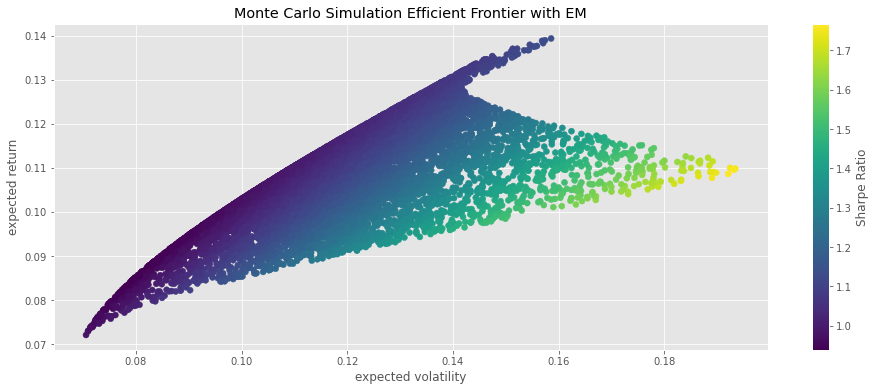

In [230]:
# the charts

plt.figure(figsize = (16,6))
plt.scatter(port_risk, port_returns, c = port_risk / port_returns, marker = 'o',cmap='viridis')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe Ratio')
plt.title('Monte Carlo Simulation Efficient Frontier with EM')

plt.show();

In [231]:
weightMin = all_wts[port_risk.argmin()]
GMV=np.sqrt(np.dot(weightMin.T, np.dot(combinedReturns.cov()*12, weightMin)))
GMV

0.07057564824410664

### 3.2. Populate the Efficient Frontier:
--------------------------------

#### We use Efficient Frontier to find the optimal weights along Efficient Frontier

In [232]:
trets = np.linspace(GMV-0.001, 0.14, 50)
tvols=[]
weightlist=[]

bnds = tuple((0.0,1) for x in range(len(combinedAssets)))
initial = len(combinedAssets) * [1/len(combinedAssets)]

for ret in trets:
    cons = ({"type" : "eq", "fun" : lambda x: statsEF(x)[0] - ret},
        {"type" : "eq", "fun" : lambda x: np.sum(x) - 1})
    
    opt = sco.minimize(min_func_var, initial, method="SLSQP", 
                    bounds=bnds, constraints= cons)
    
    tvols.append(np.sqrt(opt["fun"]))
    weightlist.append(opt['x'])
tvols = np.array(tvols)
weightlist = np.array(weightlist)

Text(0.5, 1.0, 'Efficient Frontier + GMV + MSR')

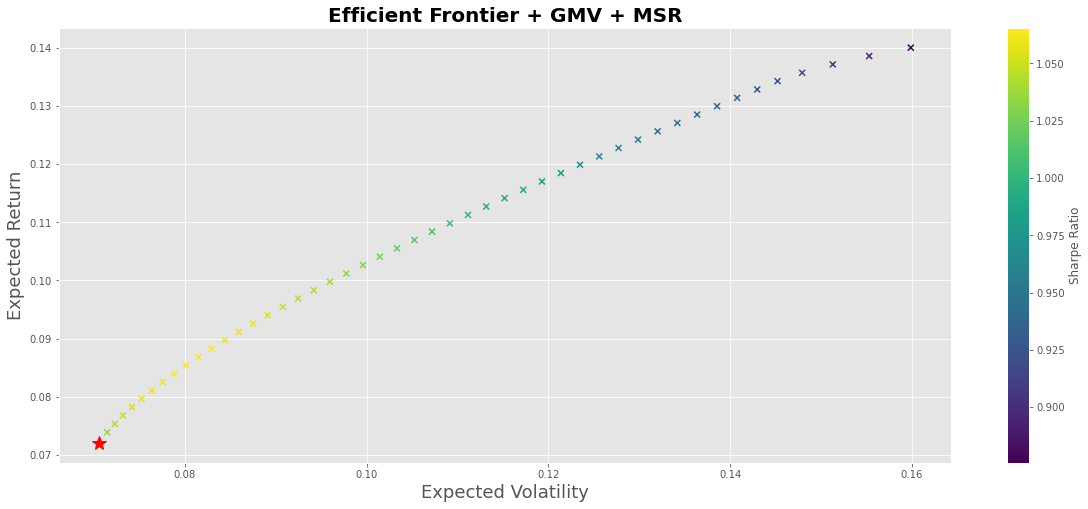

In [233]:
plt.figure(figsize=(20,8))

#Efficient Frontier
plt.scatter(tvols[3:], trets[3:], c=(trets/tvols)[3:], marker="x")


#Min Var portfolio    
plt.plot(statsEF(weightMin)[1], statsEF(weightMin)[0],
         "r*", markersize=15)

plt.grid(True)
plt.xlabel("Expected Volatility", fontsize=18)
plt.ylabel("Expected Return", fontsize=18)
plt.colorbar(label="Sharpe Ratio")
plt.title("Efficient Frontier + GMV + MSR", fontsize=20, weight="bold")

In [234]:
wt_pd=pd.DataFrame(data=(weightlist*100).round(2), columns=combinedAssets, index=trets.round(3))

In [235]:
vols=pd.DataFrame(data=tvols.round(3),columns=['volatility'],index=trets.round(3))
wt_pd=pd.concat([wt_pd,vols],axis=1)
wt_pd.index.name='Portfolio Return'

### 3.3. Select the Portfolio Weights leads to a Return > 0.10 and Volatility<0.15
#### we select the optimal weight combination on the efficient frontier.

In [236]:
wt_pd.loc[(wt_pd.index > 0.10)&(wt_pd['volatility'] < 0.15)]

,Fixed Income,Equity,Commodity,volatility
Portfolio Return,,,,
0.101,52.02,38.27,9.72,0.098
0.103,49.74,40.08,10.18,0.100
0.104,47.46,41.90,10.64,0.101
0.106,45.18,43.72,11.10,0.103
0.107,42.90,45.53,11.57,0.105
0.108,40.62,47.35,12.03,0.107
0.110,38.34,49.17,12.49,0.109
0.111,36.06,50.99,12.95,0.111
0.113,33.78,52.80,13.42,0.113


#### We select the weight [6.29%,74.72%,18.99%] on efficient frontier which gives us a return of 13%, and a volatiity of 13.9%

In [237]:
selWeight=np.array([6.29,74.72,18.99])/100
print('give equal Weight to Equity, FixedIncome,and Commodity')
weightPortSel=pd.DataFrame(data=selWeight, index=combinedAssets, columns=['Weight%'] )
weightPortSel

give equal Weight to Equity, FixedIncome,and Commodity


,Weight%
Fixed Income,0.0629
Equity,0.7472
Commodity,0.1899


In [238]:
selcov=combinedReturns.cov() * 12

In [239]:
selret=np.dot(combinedReturns.mean(),selWeight)*12
selVariance = np.dot(selWeight.T, np.dot(selcov, selWeight))
selVolatility = np.sqrt(selVariance)
print('Portfolio Return: {}'.format(round(selret,3)))
print('Portfolio Variance: {}'.format(round(selVariance,3)))
print('Portfolio Volatility: {}'.format(round(selVolatility,3)))

weightPortSel

Portfolio Return: 0.13
Portfolio Variance: 0.019
Portfolio Volatility: 0.139


,Weight%
Fixed Income,0.0629
Equity,0.7472
Commodity,0.1899


### 3.4. Backtest

In [240]:
combinedWeights, combinedPortVol= backtestSel(combinedReturns, dateToday)

In [241]:
weight_sel=pd.DataFrame.from_dict(combinedWeights).T
weight_sel.columns=combinedReturns.columns
weight_sel_percent=round(weight_sel*100,2)
weight_sel_percent.index.name='weight%'

In [242]:
selret_back=round(combinedReturns.tail(110),5)

In [243]:
selport_rets=(selret_back*selWeight).sum(axis=1)
selport_rets=pd.DataFrame(selport_rets)
selport_rets.columns=['Selected Weight Portfolio Return']

In [244]:
selportIndex = returnIndex(selport_rets,datetime(2012,12,31))
selportIndex.columns=['Selected Weight Portfolio Return']
selportIndex = pd.concat([selportIndex, fixRiskportIndex], axis=1)

### 3.5. Comparison with All other strategies
#### We compare porfolio performance of Selected weight portfoil, Target Risk Portfolio with Min Var Strategy, and ERC Strategy, in the backtest of time window from 2013 to the date.
#### We can see our Target Risk Portfolio performs best in all strategies given the cumulative return.
#### In addtion, the return of this portfolio locates on the efficient frontier, the allocaiton to the assets is diversified. The risk level is affordable as well.

In [246]:
p=plotIndex(selportIndex,'Cumulative Return')
show(p)
output_notebook()

Loading BokehJS ...

## 4. Stress Test
### 4.1. Maximum Draw Down

#### Our Target Risk strategy has lower max drawdown compared to S&P500, and less recovery time than S&P500
#### But Our Strategy has the best performance among these strategies

In [247]:
previous_peaks= selportIndex.cummax()

In [248]:
drawdown = pd.DataFrame((selportIndex-previous_peaks))
p=plotIndex(drawdown,'Drawdown')
p.legend.location="bottom_left"
show(p)
output_notebook()

Loading BokehJS ...

### 4.2. Recovery Time
#### From the recovery time table, we can see S&P 500 also takes the longest time to get recovery.

In [249]:
drawdownMin=pd.DataFrame(data=round(drawdown.min(),2),columns=['Drawdown in Percentage'])
l=[]
for i in range(len(drawdown.min())):
    c=0
    n=0
    for row in drawdown[drawdown.columns[i]]:
        if row == drawdown.min()[i] and c==0:
            c=1
        if c==1:
            n=n+1
        if c==1 and row==0:
            break
    l.append(n-1)
l=pd.Series(l,name='Recovery time in Month',index=drawdownMin.index)
drawdownMin=pd.concat([drawdownMin,l],axis=1)   

#### Regarding the max draw down and recovery time of S&P 500. We would not suggest that make up our Equity portfolio by S&P 500 only despite that would give us a higher return, however, a much higher volatile in swing period.

In [250]:
drawdownMin

,Drawdown in Percentage,Recovery time in Month
Selected Weight Portfolio Return,-41.09,2
Target Risk whole Portfolio Return,-30.46,4
Minimum Variance Portfolio Return,-11.38,2
ERC Portfolio Return,-11.38,2
AGG,-8.29,0
S&P500,-75.52,4


In [251]:
portReturns=selport_rets

### 4.3. Value at Risk
#### From the historical return distribution of our portfolio, we can see that the VaR for our portfolio is 0.04, which represents with 95% confidence that our portfolio will not exceed losses greater than 0.04 per USD over one month period.

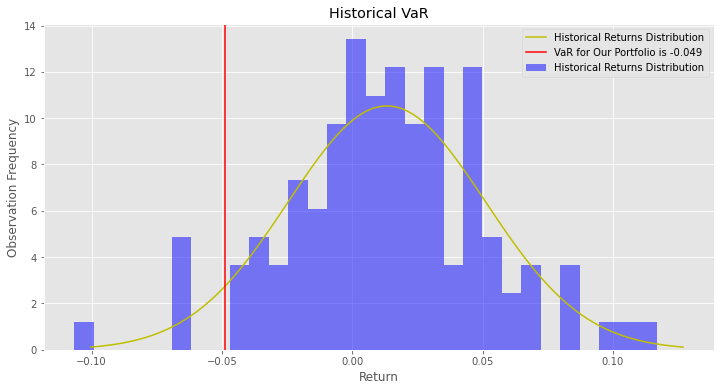

In [252]:
port_mean = portReturns.mean()
 
port_stdev = portReturns.std()

conf_level = 0.05

var = norm.ppf(conf_level, port_mean, port_stdev)

plt.figure(figsize=(12,6))
plt.hist(portReturns,bins=30, color='b',density=True, histtype='stepfilled',stacked=True, alpha=0.5)
x = np.linspace(port_mean - 3 * port_stdev, port_mean + 3 * port_stdev, 100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev),color='y')
plt.axvline(var, color='red', linestyle='solid')
plt.legend(['Historical Returns Distribution',
            'VaR for Our Portfolio is '+ str(round(float(var),3)),
            'Historical Returns Distribution'])

plt.title('Historical VaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');
plt.show()


## 5. Investment

#### We Examine two ways of rebalancing. One is using a fixed optimal weight we got by the previous analysis.It gives us a higher return of 230.21 Million with capital return of 91.84%; the other one is taking different a higher weight to fixed income asset in the last 24 months and lower weight to equity asset to decrease the volitility of our portfolio so that reduce the affect by the unpredictable volatile market risk as the time goes toward the maturity date.
#### Despite rebalance with different weight combination will give us a return of 216.44 Million with a capital return of 80.37% which is a bit lower than the one with fixed weight combination, we are still going to propose the strategy of rebalancing with different weights for assets regarding to the length till the marturity date, considering the the requirement of pay off all capital to the client and the requirement of decreasing the risk in the period close to the marturity date.


In [253]:
ivtRet=combinedReturns.copy()

In [254]:
ivtRet=ivtRet.tail(120)
ivtRet

,Fixed Income,Equity,Commodity
2012-02-29,0.016068,0.060872,0.020578
2012-03-30,-0.002591,0.048373,-0.025218
2012-04-30,0.012612,-0.015786,0.005932
2012-05-31,-0.004567,-0.069870,-0.107365
2012-06-29,0.014186,0.033724,0.007004
...,...,...,...
2021-09-30,-0.002951,-0.057530,0.019205
2021-10-29,0.001038,0.074962,0.054415
2021-11-30,-0.004925,0.028864,-0.085931
2021-12-31,0.014018,0.044434,0.083639


### 5.1. Rebalance Monthly with the optimal allocation weight
#### Rebalance with combination of [ Fixed Income:6.29%, Equity: 74.72%, Commodity: 18.99% ] which is decided with the Target Risk Strategy and Efficient Frontier.
#### for 5.1, we will keep the weight unchanged for each time rebalancing.

In [255]:
wght=selWeight
ini_cap=120
ini_ass=(wght*ini_cap).tolist()
tenor=120 #number of months
minpay=1.001

In [256]:
print("Initial capital allocation to 3 asset Sets are: ")
print(np.array([ini_ass]).round(2))

Initial capital allocation to 3 asset Sets are: 
[[ 7.55 89.66 22.79]]


In [257]:
perReb = 1+ivtRet
perReb.iloc[0] = (ini_ass*perReb.iloc[0]).round(3)

In [258]:
perReb['Portfolio']=(perReb.iloc[:,:3]).sum(axis=1) 
perReb['Payout']=max(minpay,(1/tenor) * perReb['Portfolio'][0])
perReb['Cummulative Payout']=perReb['Payout'][0]

In [259]:
for row in range(1,len(perReb)):
    perReb.iloc[row,:3]=(perReb['Portfolio'][row-1]-perReb['Payout'][row-1])*wght*perReb.iloc[row,:3]
    perReb['Portfolio'][row]=sum(perReb.iloc[row,:3])
    perReb['Payout'][row]=max(minpay,perReb['Portfolio'][row]* 1/(tenor-row))
    perReb['Cummulative Payout'][row]=perReb['Payout'][:row+1].sum()

perReb['Payout'][-1] = perReb['Portfolio'][-1]
print('_ '*30)
print("Total payout is: "+ str(round(perReb['Payout'].sum(),3))+" Million")
print("The Return in Capital is: " + str(round((perReb['Payout'].sum()/120-1)*100,2))+'%')
print('_ '*30)

perReb.round(2)

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Total payout is: 230.206 Million
The Return in Capital is: 91.84%
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


,Fixed Income,Equity,Commodity,Portfolio,Payout,Cummulative Payout
2012-02-29,7.67,95.12,23.26,126.05,1.05,1.05
2012-03-30,7.84,97.92,23.14,128.90,1.08,2.13
2012-04-30,8.14,93.99,24.42,126.55,1.07,3.21
2012-05-31,7.86,87.21,21.27,116.33,1.00,4.21
2012-06-29,7.36,89.08,22.06,118.50,1.02,5.23
...,...,...,...,...,...,...
2021-09-30,1.26,14.10,3.87,19.23,3.85,213.51
2021-10-29,0.97,12.36,3.08,16.41,4.10,217.62
2021-11-30,0.77,9.46,2.14,12.36,4.12,221.74
2021-12-31,0.53,6.43,1.70,8.66,4.33,226.06


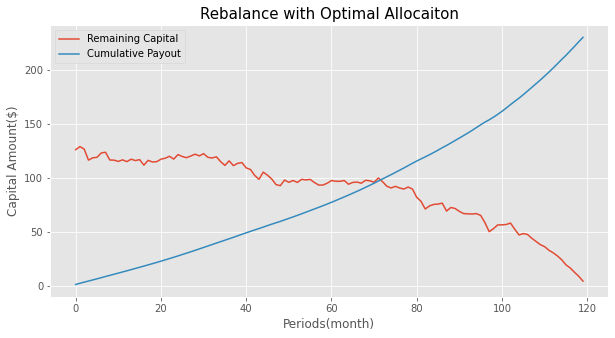

In [260]:
fig1=perReb[['Portfolio','Cummulative Payout']].copy()
fig1.reset_index(drop=True, inplace=True)
fig1.plot(figsize=(10,5), grid=True)
plt.title("Pension Fund Scheme")
plt.xlabel('Periods(month)', fontsize=12)
plt.ylabel('Capital Amount($)', fontsize=12)
plt.title('Rebalance with Optimal Allocaiton', fontsize=15)
plt.legend(['Remaining Capital','Cumulative Payout'],fontsize=10)

### Based on our strategy, our client would receive stable and increasing payouts, by the time of marturity, our client would receive 230.21 Million in total, which is 91.84%

### 5.2. Rebalance Monthly with different weights allocation
#### Rebalance with Optimal weights of [ Fixed Income:6.29%, Equity: 74.72%, Commodity: 18.99% ] for the first 84 months. 
#### For the remaining 36 months, lift the weight of Fixed Income asset with a weight combination of [ Fixed Income: 49.23%, Equity: 40.49%, Commodity: 10.28%], which is also in line with the efficient frontier but will decline the volitility of our portfolio below 10%, aiming to decrease the affect by the unpredictable volatile market risk as the time goes to the maturity date.

In [261]:
wght2=np.array([49.23,40.49,10.28])/100
tenor2=84

In [262]:
print("Initial capital allocation to 3 asset Sets are: ")
print(np.array([ini_ass]).round(2))

Initial capital allocation to 3 asset Sets are: 
[[ 7.55 89.66 22.79]]


In [263]:
perChg = 1+ivtRet
perChg.iloc[0] = (ini_ass*perChg.iloc[0]).round(3)

In [264]:
perChg['Portfolio']=(perChg.iloc[:,:3]).sum(axis=1) 
perChg['Payout']=max(minpay,(1/120) * perChg['Portfolio'][0])
perChg['Cummulative Payout']=perChg['Payout'][0]

In [265]:
for row in range(1,tenor2):
    perChg.iloc[row,:3]=(perChg['Portfolio'][row-1]-perChg['Payout'][row-1])*wght*perChg.iloc[row,:3]
    perChg['Portfolio'][row]=sum(perChg.iloc[row,:3])
    perChg['Payout'][row]=max(minpay,perReb['Portfolio'][row]* 1/(120-row))
    perChg['Cummulative Payout'][row]=perChg['Payout'][:row+1].sum()
    
for row2 in range(tenor2,120):
    perChg.iloc[row2,:3]=(perChg['Portfolio'][row2-1]-perChg['Payout'][row2-1])*wght2*perChg.iloc[row2,:3]
    perChg['Portfolio'][row2]=sum(perChg.iloc[row2,:3])
    perChg['Payout'][row2]=max(minpay,perChg['Portfolio'][row2]* 1/(120-row2))
    perChg['Cummulative Payout'][row2]=perChg['Payout'][:row2+1].sum()
    
perChg['Payout'][-1] = perChg['Portfolio'][-1]
print('_ '*30)
print("Total payout is: "+ str(round(perChg['Payout'].sum(),3))+" Million")
print("The Return in Capital is: " + str(round((perChg['Payout'].sum()/120-1)*100,2))+'%')
print('_ '*30)

perChg.round(2)

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Total payout is: 216.435 Million
The Return in Capital is: 80.36%
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


,Fixed Income,Equity,Commodity,Portfolio,Payout,Cummulative Payout
2012-02-29,7.67,95.12,23.26,126.05,1.05,1.05
2012-03-30,7.84,97.92,23.14,128.90,1.08,2.13
2012-04-30,8.14,93.99,24.42,126.55,1.07,3.21
2012-05-31,7.86,87.21,21.27,116.33,1.00,4.21
2012-06-29,7.36,89.08,22.06,118.50,1.02,5.23
...,...,...,...,...,...,...
2021-09-30,7.90,6.14,1.69,15.73,3.15,203.29
2021-10-29,6.20,5.48,1.36,13.04,3.26,206.55
2021-11-30,4.79,4.07,0.92,9.78,3.26,209.81
2021-12-31,3.26,2.76,0.73,6.74,3.37,213.18


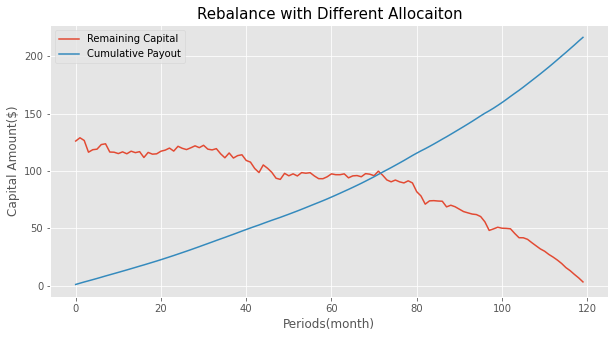

In [266]:
fig2=perChg[['Portfolio','Cummulative Payout']].copy()
fig2.reset_index(drop=True, inplace=True)
fig2.plot(figsize=(10,5), grid=True)
plt.title("Pension Fund Scheme")
plt.xlabel('Periods(month)', fontsize=12)
plt.ylabel('Capital Amount($)', fontsize=12)
plt.title('Rebalance with Different Allocaiton', fontsize=15)
plt.legend(['Remaining Capital','Cumulative Payout'])

#### Based on our strategy, our client would receive stable and increasing payouts, by the time of marturity, our client would receive 216.44 Million in total, which is 80.37%

### 5.3. Conclusion
#### Despite rebalancing with different weight will give a lower return, we still recommend rebalancing with adjusting weight in the late stage of investment. This could be a better strategy for pension fund investment. We should be more prudent when close to marturity of investment due to the payoff requirement of the remaining capital. If the market occurs go down significantly due to an unpredictable huge swing in the later stage, this strategy will reduce the risk of lossing huge amount.

###### *Note1. We assume the trading fee as a percentage of payout is covered.
###### *Note2. we can also considered paying cash flow by drawing down all from equity, in which process, the equity weight will go down, no only fit the liquidity requirement but also achieved the goal of equity weight decreasing as the investment go to marturity date. I will leave it as an option due to the limited time fo this project.

# END